<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled210porphREE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[saved] TDSE_Porphyrin_SAM_REE.gif


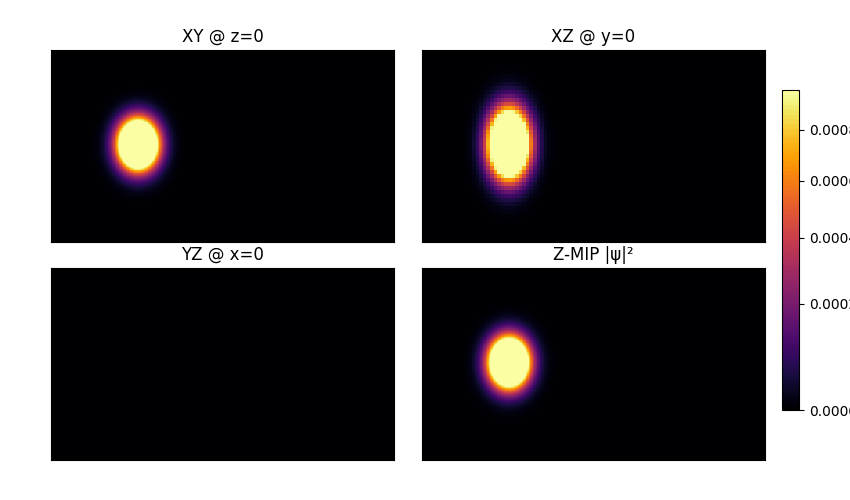

[saved] TDSE_Porphyrin_SAM_REE_final.png


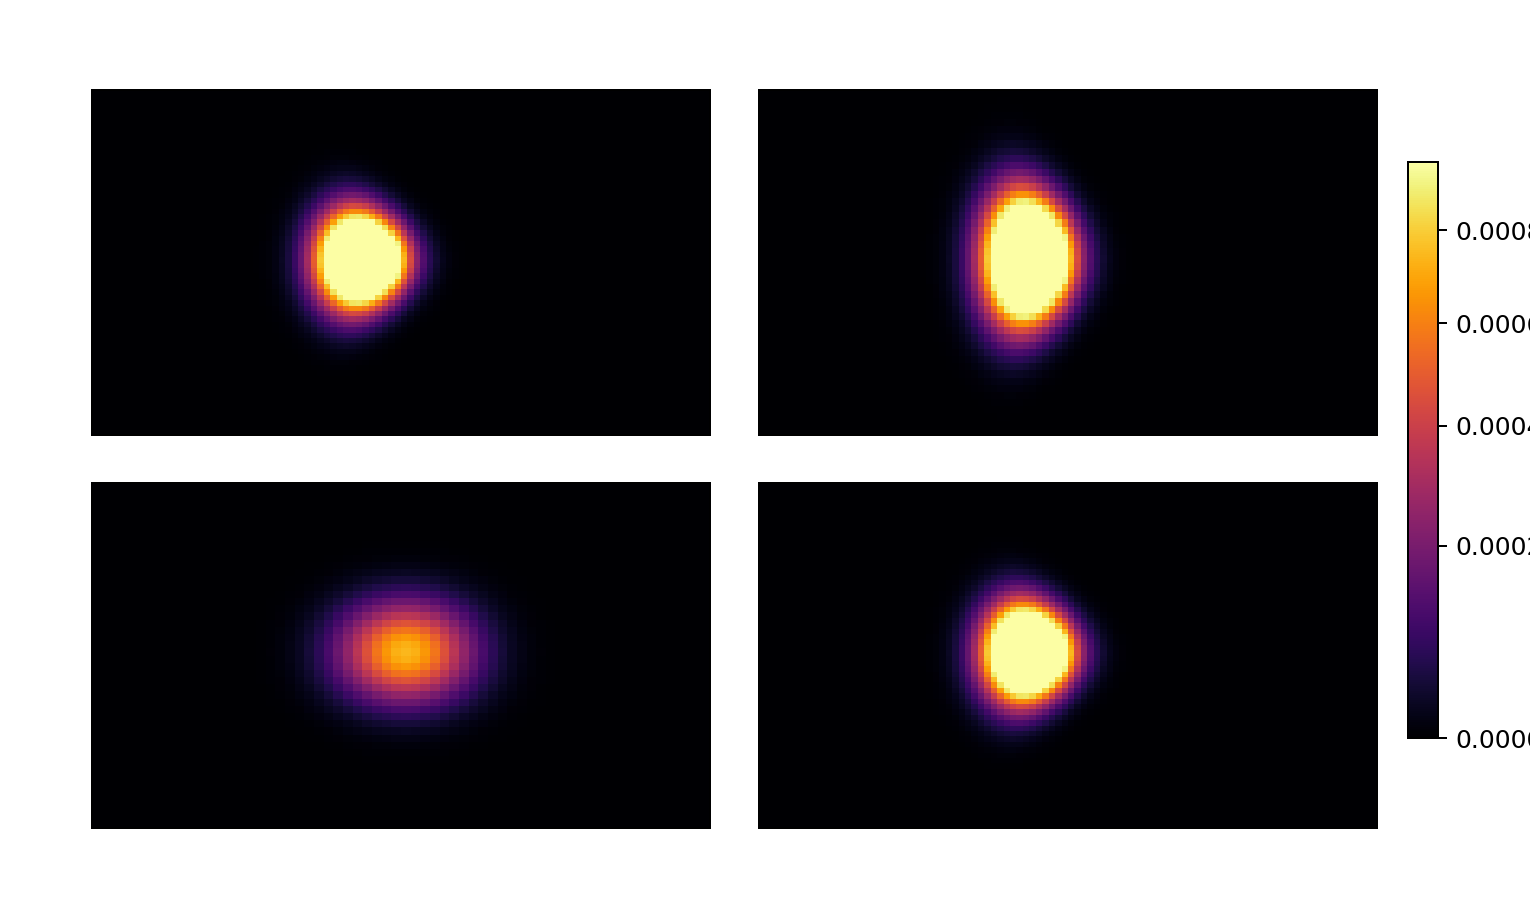

('TDSE_Porphyrin_SAM_REE.gif',
 'TDSE_Porphyrin_SAM_REE_final.png',
 'TDSE_Porphyrin_SAM_REE_final_density.npz')

In [ ]:
# 3D TDSE tunnelling movie generator (GIF; no ffmpeg needed)
# Presets included: Porphyrin SAM + REE, Graphene control, Fe2+ porphyrin, Fe3+ porphyrin
# Outputs: <name>.gif, <name>_final.png, <name>_final_density.npz in the current working directory

import numpy as np
import os, json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import PowerNorm
from IPython.display import Image, display

def run_tdse_movie(preset_name, params, n_frames=60, steps_per_frame=2, show_inline=True):
    # --- Domain ---
    Nx, Ny, Nz = params.get("Nx", 96), params.get("Ny", 64), params.get("Nz", 48)
    Lx, Ly, Lz = params.get("Lx", 70.0), params.get("Ly", 35.0), params.get("Lz", 26.0)
    dt = params.get("dt", 0.06)

    dx, dy, dz = Lx/Nx, Ly/Ny, Lz/Nz
    x = np.linspace(-Lx/2, Lx/2 - dx, Nx, dtype=np.float32)
    y = np.linspace(-Ly/2, Ly/2 - dy, Ny, dtype=np.float32)
    z = np.linspace(-Lz/2, Lz/2 - dz, Nz, dtype=np.float32)
    X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

    hbar = 1.0
    m = 1.0

    # --- Base potential: barrier + pocket + soft walls + complex absorber ---
    barrier_center = 0.0
    barrier_width  = params.get("barrier_w", 2.0)
    barrier_height = params.get("barrier_h", 0.35)
    pocket_x_start = params.get("pocket_x_start", 9.0)
    pocket_depth   = params.get("pocket_depth", -15.0)

    V0 = np.zeros((Ny, Nx, Nz), dtype=np.float32)
    barrier_mask = (np.abs(X - barrier_center) < (barrier_width/2)).astype(np.float32)
    V0 += barrier_height * barrier_mask
    V0 += pocket_depth * (X > pocket_x_start)

    # Soft walls
    edge_soft = 5.0
    V0 += 0.02*(np.tanh((np.abs(X)-(Lx/2-edge_soft))/2)+1.0)
    V0 += 0.02*(np.tanh((np.abs(Y)-(Ly/2-edge_soft))/2)+1.0)
    V0 += 0.02*(np.tanh((np.abs(Z)-(Lz/2-edge_soft))/2)+1.0)

    # Complex absorbing potential (CAP)
    cap_margin=5.0; eta=2.0e-4
    def _cap(coord,L,margin):
        r = np.maximum(np.abs(coord)-(L/2 - margin),0)/margin
        return r**4
    CAP = -1j*eta*(_cap(X,Lx,cap_margin)+_cap(Y,Ly,cap_margin)+_cap(Z,Lz,cap_margin)).astype(np.complex64)
    V0_cap = (V0.astype(np.float32) + CAP)

    # --- Initial Gaussian wavepacket ---
    x0,y0,z0 = params.get("x0",-18.0), 0.0, 0.0
    kx0,ky0,kz0 = params.get("kx0",1.45), 0.0, 0.0
    sigx,sigy,sigz = params.get("sigx",3.2), 3.6, 3.6
    psi = np.exp(-((X-x0)**2/(2*sigx**2) + (Y-y0)**2/(2*sigy**2) + (Z-z0)**2/(2*sigz**2))).astype(np.complex64)
    psi *= np.exp(1j*(kx0*X + ky0*Y + kz0*Z))
    norm0 = np.sqrt(np.sum(np.abs(psi)**2)*dx*dy*dz).astype(np.float32)
    psi /= norm0

    # --- FFT kinetic propagator ---
    kx = 2*np.pi*np.fft.fftfreq(Nx, d=float(dx))
    ky = 2*np.pi*np.fft.fftfreq(Ny, d=float(dy))
    kz = 2*np.pi*np.fft.fftfreq(Nz, d=float(dz))
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='xy')
    T_k = (hbar**2)*(KX**2 + KY**2 + KZ**2)/(2*m)
    expT = np.exp(-1j * T_k * (dt/hbar)).astype(np.complex64)

    def step(psi, V):
        eVh = np.exp(-1j * V * (dt/(2*hbar))).astype(np.complex64)
        psi = psi * eVh
        psi_k = np.fft.fftn(psi, axes=(0,1,2))
        psi_k = psi_k * expT
        psi   = np.fft.ifftn(psi_k, axes=(0,1,2))
        psi   = psi * eVh
        return psi

    # --- Gates: H (aperture/focusing), C (bias), I (impulse) ---
    E_dc_C = params.get("E_dc_C", 0.06)
    E0_C   = params.get("E0_C", 0.12)
    w_C    = params.get("w_C", 0.10)

    kappa_yz = params.get("kappa_yz", 0.028)
    xwin_w   = params.get("xwin_w", 6.0)
    X_win    = np.exp(-(X**2)/(2*xwin_w**2)).astype(np.float32)

    t_arrival = (0.0 - x0)/max(kx0, 1e-6)
    t0 = float(t_arrival)
    tauI  = params.get("tauI", 1.0)
    E_pI  = params.get("E_pI", 0.24)
    A_loc = params.get("A_loc", 0.34)
    sigI  = params.get("sigI", 6.0)
    env_center = params.get("env_center", 11.5)
    ENV_I = np.exp(-(((X-env_center)**2 + Y**2 + Z**2)/(2*sigI**2))) * (X>2.0)

    def V_C(t): return V0_cap - (E_dc_C + E0_C*np.sin(w_C*t))*X
    def V_H(t): return V0_cap + 0.5*kappa_yz*((Y**2)+(Z**2))*X_win
    def gI(t):  return np.exp(-((t - t0)**2)/(2*tauI**2))
    def V_I(t): return V0_cap - (E_pI*gI(t))*X - A_loc*gI(t)*ENV_I
    def V_HCI(t): return (V_H(t) + V_C(t) + V_I(t) - 2*V0_cap)

    # --- Figure for animation ---
    fig, axes = plt.subplots(2, 2, figsize=(8.5, 5.0))
    (ax_xy, ax_xz), (ax_yz, ax_mip) = axes
    for ax in (ax_xy, ax_xz, ax_yz, ax_mip):
        ax.set_xticks([]); ax.set_yticks([])

    extent_xy = (-Lx/2, Lx/2 - dx, -Ly/2, Ly/2 - dy)
    extent_xz = (-Lx/2, Lx/2 - dx, -Lz/2, Lz/2 - dz)
    extent_yz = (-Ly/2, Ly/2 - dy, -Lz/2, Lz/2 - dz)
    dens = np.abs(psi)**2
    vmax = np.percentile(dens, 99.5)
    im_xy  = ax_xy.imshow(dens[:, :, Nz//2], extent=extent_xy, origin='lower',
                          aspect='auto', norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    ax_xy.set_title("XY @ z=0")
    im_xz  = ax_xz.imshow(dens[Ny//2, :, :].T, extent=extent_xz, origin='lower',
                          aspect='auto', norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    ax_xz.set_title("XZ @ y=0")
    im_yz  = ax_yz.imshow(dens[:, Nx//2, :].T, extent=extent_yz, origin='lower',
                          aspect='auto', norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    ax_yz.set_title("YZ @ x=0")
    im_mip = ax_mip.imshow(dens.max(axis=2), extent=extent_xy, origin='lower',
                           aspect='auto', norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    ax_mip.set_title("Z-MIP |ψ|²")
    cax = fig.add_axes([0.92, 0.18, 0.02, 0.64])
    cbar = fig.colorbar(im_xy, cax=cax); cbar.set_label("Probability density")
    plt.subplots_adjust(left=0.06, right=0.90, bottom=0.08, top=0.90, wspace=0.08, hspace=0.14)

    # --- Animate & save GIF ---
    def update(frame_idx):
        t_now = float(dt)*steps_per_frame*frame_idx
        nonlocal psi
        for _ in range(int(steps_per_frame)):
            psi = step(psi, V_HCI(t_now))
        d = np.abs(psi)**2
        vmax = np.percentile(d, 99.5)
        im_xy.set_norm(PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax)); im_xy.set_data(d[:, :, Nz//2])
        im_xz.set_norm(PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax)); im_xz.set_data(d[Ny//2, :, :].T)
        im_yz.set_norm(PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax)); im_yz.set_data(d[:, Nx//2, :].T)
        im_mip.set_norm(PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax)); im_mip.set_data(d.max(axis=2))
        return (im_xy, im_xz, im_yz, im_mip)

    gif_path = f"{preset_name}.gif"
    ani = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)
    ani.save(gif_path, writer=PillowWriter(fps=15))
    plt.close(fig)

    # --- Final snapshot ---
    d = np.abs(psi)**2
    fig2, axes2 = plt.subplots(2, 2, figsize=(8.5, 5.0))
    (ax2_xy, ax2_xz), (ax2_yz, ax2_mip) = axes2
    for ax in (ax2_xy, ax2_xz, ax2_yz, ax2_mip):
        ax.set_xticks([]); ax.set_yticks([])
    vmax = np.percentile(d, 99.5)
    ax2_xy.imshow(d[:, :, Nz//2], extent=extent_xy, origin='lower', aspect='auto',
                  norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    ax2_xz.imshow(d[Ny//2, :, :].T, extent=extent_xz, origin='lower', aspect='auto',
                  norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    ax2_yz.imshow(d[:, Nx//2, :].T, extent=extent_yz, origin='lower', aspect='auto',
                  norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    ax2_mip.imshow(d.max(axis=2), extent=extent_xy, origin='lower', aspect='auto',
                   norm=PowerNorm(gamma=0.7, vmin=0.0, vmax=vmax), cmap="inferno")
    cax2 = fig2.add_axes([0.92, 0.18, 0.02, 0.64])
    cbar2 = fig2.colorbar(ax2_xy.images[0], cax=cax2); cbar2.set_label("Probability density")
    plt.subplots_adjust(left=0.06, right=0.90, bottom=0.08, top=0.90, wspace=0.08, hspace=0.14)
    png_path = f"{preset_name}_final.png"
    fig2.savefig(png_path, dpi=180); plt.close(fig2)

    # Save final density for analysis
    npz_path = f"{preset_name}_final_density.npz"
    np.savez_compressed(npz_path, density=d, x=x, y=y, z=z, params=params)

    # Show inline previews
    if show_inline:
        print(f"[saved] {gif_path}")
        display(Image(filename=gif_path))
        print(f"[saved] {png_path}")
        display(Image(filename=png_path))
    return gif_path, png_path, npz_path

# --- Presets (edit these to taste) ---
Porphyrin_SAM_REE = dict(
    Nx=96, Ny=64, Nz=48, Lx=70.0, Ly=35.0, Lz=26.0,
    barrier_w=2.0, barrier_h=0.28, pocket_x_start=9.0, pocket_depth=-15.0,
    x0=-18.0, kx0=1.45, sigx=3.2,
    E_dc_C=0.06, E0_C=0.12, w_C=0.10,
    kappa_yz=0.028, xwin_w=6.0,
    tauI=1.0, E_pI=0.24, A_loc=0.34, sigI=6.0, env_center=11.5,
    dt=0.06
)

Graphene_ctrl = dict(
    Nx=96, Ny=64, Nz=48, Lx=70.0, Ly=35.0, Lz=26.0,
    barrier_w=2.4, barrier_h=0.42, pocket_x_start=10.0, pocket_depth=-12.0,
    x0=-18.0, kx0=1.45, sigx=3.2,
    E_dc_C=0.04, E0_C=0.08, w_C=0.08,
    kappa_yz=0.040, xwin_w=6.0,
    tauI=1.0, E_pI=0.18, A_loc=0.20, sigI=6.0, env_center=11.5,
    dt=0.06
)

Fe2_por = dict(**Porphyrin_SAM_REE)
Fe2_por.update(dict(barrier_h=0.30, E0_C=0.10, A_loc=0.28))

Fe3_por = dict(**Porphyrin_SAM_REE)
Fe3_por.update(dict(barrier_h=0.26, E0_C=0.11, A_loc=0.32))

# --- Run the movies you want ---
run_tdse_movie("TDSE_Porphyrin_SAM_REE", Porphyrin_SAM_REE, n_frames=60, steps_per_frame=2)
# Uncomment any of these to render more:
# run_tdse_movie("TDSE_Graphene_ctrl", Graphene_ctrl, n_frames=60, steps_per_frame=2)
# run_tdse_movie("TDSE_Fe2_por", Fe2_por, n_frames=60, steps_per_frame=2)
# run_tdse_movie("TDSE_Fe3_por", Fe3_por, n_frames=60, steps_per_frame=2)